In [0]:
# !pip install numpy Cython pandas scipy typing cyvcf2

In [0]:
# !git clone https://github.com/Jiarong000/data.git

In [2]:
import os
print(os.listdir())
print(os.listdir('data'))
print(os.getcwd())

['.config', 'sample_data']


FileNotFoundError: ignored

In [3]:
import subprocess
import warnings
import numpy as np
import pandas as pd
import time
import math
from scipy.stats import bernoulli as bn
from cyvcf2 import VCF, Writer, Variant
from typing import *
import os
import collections
from random import seed
from random import randint
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

ModuleNotFoundError: ignored

In [0]:
class SNPsPool(np.ndarray):
    """
    Simulates the different steps of a genotype pooling process.
    Builds the pooling design matrix.
    Encodes pooled genotypes per group.
    Decodes encoded genotypes of the pools back to individual genotypes.
    """
    def __new__(cls,
                shape: tuple = (4, 4),  #default, in case not assigned
                id_len: int = 8,
                pools_nb: int = 8,
                pools_size: int = 4) -> np.ndarray:
        """
        Define the basic structure for a pool i.e.
        a squared matrix to fill with the variables IDs/GT/GL.
        :param shape: tuple, shape of the pool
        :param id_len: max number of char of the variables IDs
        :return: a matrix with dims 'shape', filled with str types
        """
        cls.id_len = id_len
        id = 'U' + str(cls.id_len)
        cls.pools_nb = pools_nb
        cls.pools_size = pools_size
        return np.empty_like(super(SNPsPool, cls).__new__(cls, shape),
                             dtype=id)

    def design_matrix(self, random: bool = False) -> np.ndarray:
        """
        That function is not intended to be called explicitly.
        :param random: bool for dispatching idv randomly in the matrix?
        :return: design matrix. Numpy array.
        """
        pools_size: int = self.pools_size
        design: np.ndarray = np.zeros((self.pools_nb, self.size), dtype=int)
        if not random:
            for i in range(int(self.pools_nb/self.ndim)):
                j = i * pools_size
                design[i, j:j+pools_size] = [1]*pools_size
            for i in range(int(self.pools_nb/self.ndim), self.pools_nb):
                j = i - pools_size
                design[i,
                       [j+k*pools_size for k in range(pools_size)]] = 1
        return design

    def set_subset(self, subset: np.ndarray) -> np.ndarray:
        """
        Fills the pooling matrix according to the (default) design
        and the input list of samples.
        :param subset: 1D-nparray-like object with the variables IDs
        :return: pooling matrix with samples' names.
        """
        self.__setattr__('subset', subset)  # from split_pools
        sub = self.__getattribute__('subset')
        try:
            for i in range(self.shape[0]):
                self[i, :] = sub[:self.shape[1]]
                sub = sub[self.shape[1]:]
        except Exception as exc:
            if len(self.subset) > self.size:
                raise ValueError('The input you gave is too long') from exc
            if len(self.subset) < self.size:
                raise ValueError('The input you gave is too short') from exc
            if type(self.subset) != np.ndarray and type(self.subset) != list:
                raise TypeError('The input is not a 1D-array-like') from exc
            if len(self.subset) > 0 and type(self.subset[0]) != str:
                raise TypeError('The input does not contain str-type elements') from exc

        return self

    def get_subset(self) -> np.ndarray:
        """
        Flatten the matrix of pooled samples identifiers.
        :return: flattened array of samples identifiers or genotypes.
        """
        ids = self.flatten()  # .reshape(1, self.size)
        return ids

    def pools_list(self) -> List[str]:
        """
        Put samples into matrix structure, just for representation
        :return: list of matrix-shaped samples identifiers
        """
        design = self.design_matrix()
        if np.where(self == '', False, True).all():
            pools_: List[str] = []
            for i in range(design.shape[0]):
                cache = (design[i, :].reshape(self.shape) == False)  # cache = ~design[i, :].reshape(self.shape)
                pool = np.ma.masked_array(self, mask=cache)
                pools_.append(pool.compressed())
            return pools_
            # return just for being able to print the list if wished

    def set_line_values(self, samples: list, variant: Variant,
                        sig: object = None,
                        params: List[float] = [], interp: object = None) -> None:
        """
        Attach sigmoid-transformed alternate allele frequencies to the current variant.
        :param samples: samples identifiers from the VCF-file
        :param variant: variant identifier from the VCF-file
        :param sig: sigmoid object computed from another set of pooled genotype data
        :param params: parameters to pass for the sigmoid approximation
        :param interp: interpolated sigmoid object for sigmoid approximation
        :return: variant object with attributes attached, e.g. twisted alternate allele frequency
        """
        self.__setattr__('variant', variant)  #variant.genotypes
        self.__setattr__('samples', samples)


    def get_call(self) -> np.ndarray:
        """
        Get pooled samples genotypes for a given variant
        :return:
        """
        subs = self.get_subset()
        idx = np.argwhere(np.isin(self.samples, subs))
        self.__setattr__('call', np.asarray(self.variant)[idx])
        return self.call

    def pool_genotypes(self) -> np.ndarray:
        """
        Computes genotypes of the different pools.
        :return: array of {0,1} GLs for RR|RA|AA for each pool
        """
        call: np.ndarray = self.get_call().reshape((1, self.size, 3)) 
        scores: np.ndarray = np.apply_along_axis(sum, axis=-1, arr=call[:, :, :-1])
            
        

        if np.isin(call, -1).any():
            x = np.ones((1, self.pools_nb, 1))
            y = np.asarray([-1, -1, 0])
            b = np.broadcast(x, y)
            p = np.empty(b.shape)
            p.flat = [u * v for (u, v) in b]
        else:
            pooled_gt = np.dot(self.design_matrix(),
                               np.transpose(scores)).reshape((1, self.pools_nb, 1))
            
            pooled_gt = np.broadcast_to(pooled_gt, (1, self.pools_nb, 3))
            p = np.apply_along_axis(self.pooler_gt, axis=-1, arr=pooled_gt)

        return p  # list of gt for the n pools from design matrix

    def pooler_gt(self, a: np.ndarray) -> np.ndarray:
        """
        Decodes pooled scores into individual GT.
        :param a: score from matrix-vector pooling
        :return: pool's true genotype with phase
        """
        if np.all(a == 0):  # RR * RR * RR * RR
            gt = [0, 0, 0]
        elif np.all(a == self.pools_nb):  # AA * AA * AA * AA
            gt = [1, 1, 0]
        else:
            gt = [1, 0, 0]
        return gt

    def decode_genotypes_gt(self, samples_gt: np.ndarray) -> np.ndarray:
        """
        Recomputes true genotypes of samples with/without pooling/missing data
        :param pooled_samples: Variant.genotypes (unpooled samples' true genotypes with phase)
        :return: individual samples genotypes (true genotype with phase)
        """
        pooled: np.ndarray = self.pool_genotypes()  # pooled[:, :, -1]: bool = phase of the genotype
        scores: np.ndarray = np.apply_along_axis(sum, axis=-1, arr=pooled[:, :, :-1])
        p = np.argwhere(np.isin(self.samples, self.subset))
        
        count_alt: Callable[int, int] = lambda x: 1 if 1 in x else 0
        count_ref: Callable[int, int] = lambda x: 1 if 0 in x else 0

        alt_row: int = np.sum(np.apply_along_axis(count_alt,
                                                  axis=-1,
                                                  arr=pooled[:, :self.pools_size, :-1]))
        alt_col: int = np.sum(np.apply_along_axis(count_alt,
                                                  axis=-1,
                                                  arr=pooled[:, self.pools_size:, :-1]))
        ref_row: int = np.sum(np.apply_along_axis(count_ref,
                                                  axis=-1,
                                                  arr=pooled[:, :self.pools_size, :-1]))
        ref_col: int = np.sum(np.apply_along_axis(count_ref,
                                                  axis=-1,
                                                  arr=pooled[:, self.pools_size:, :-1]))

        nb_alt: int = alt_row + alt_col
        nb_ref: int = ref_row + ref_col
        
        if np.isin(pooled, -1).any():
            x = np.ones((1, self.size, 1))
            y = np.asarray([-1, -1, 0])
            b = np.broadcast(x, y)
            decoded_gt = np.empty(b.shape)
            decoded_gt.flat = [u * v for (u, v) in b]

        else:
            encoded = np.dot(scores,
                             self.design_matrix()).reshape(1, self.size, 1)
            b = np.broadcast_to(encoded, (1, self.size, 3))
            if nb_alt == 0:
                decoded_gt = np.zeros_like(b)
            elif nb_ref == 0:
                aa = np.array([1, 1, 0])
                decoded_gt = np.tile(aa, self.size).reshape((1, self.size, 3))
            elif nb_alt == 2:
                decoder: Callable = lambda x: [1, -1, 0] if np.all(x == 2) else [0, 0, 0]
                # np.all() because of b.shape
                decoded_gt = np.apply_along_axis(decoder, axis=-1, arr=b)
            elif nb_ref == 2:  # symmetric case with ref allele in only 2 pools: individual is RR or RA
                decoder: Callable = lambda x: [0, -1, 0] if np.all(x == 2) else [1, 1, 0]
                decoded_gt = np.apply_along_axis(decoder, axis=-1, arr=b)
            else:  # nb_alt > 2 and nb_alt < 8: # nb_alt = 2*n with n > 1
                decoded_gt = np.apply_along_axis(self.multidecoder_gt, axis=-1, arr=b)

        np.put_along_axis(samples_gt,
                          np.broadcast_to(p, (self.size, 3)),
                          decoded_gt.squeeze(),
                          axis=0)

        return samples_gt


    @staticmethod
    def multidecoder_gt(a: np.ndarray): ##deleted  -> prm.GLtype
        """
        Decodes pooled scores into individual GT.
        :param a: score
        :return: true genotype with phase
        """
        if np.all(a == 2):  # RA * RA
            gt = [-1, -1, 0]
        elif np.all(a == 1) or np.all(a == 0):  # RA * RR or RR * RR
            gt = [0, 0, 0]
        else:
            gt = [1, 1, 0]
        return gt

    def __array_finalize__(self, obj: object) -> None:
        """
        Constructor needed for subclassing NumPy arrays.
        See online documentation.
        :param obj:
        :return:
        """
        if obj is None: return
        self.info = getattr(obj, 'info', None)

In [0]:
def generate_id(sample_gt):
    sample_id=[]
    for gt in sample_gt:
        is_AA=gt==np.array([1, 1, 1])
        is_RR=gt==np.array([0, 0, 1])
        is_AR=gt==np.array([1, 0, 1])
        is_RA=gt==np.array([0, 1, 1])
        if is_AA.all():
            sample_id.append('aa')
        elif is_RR.all():
            sample_id.append('rr')
        elif is_AR.all():
            sample_id.append('ar')
        elif is_RA.all():
            sample_id.append('ar')
        else:
            sample_id.append('mis')
    return sample_id

In [0]:
def access_pool(sample_gt,decoded_gt):
    decoded_gt_nophase=np.delete(decoded_gt, -1, 1)
    sample_gt_nophase=np.delete(sample_gt, -1, 1)
    access_pool=[]
    for idx in range(decoded_gt_nophase.shape[0]):
        if np.isin(decoded_gt_nophase[idx],-1).any():
            access_pool.append('mis')
        elif sum(decoded_gt_nophase[idx])==sum(sample_gt_nophase[idx]):
            access_pool.append('correct')
        else:
            access_pool.append('wrong')
    return access_pool
#return like 'mis'

### Real Data Infomation

In [8]:
# file_path=os.path.abspath(os.path.abspath('ALL.chr20.snps.gt.chunk1000.vcf.gz'))
file_path=os.path.abspath('data/ALL.chr20.snps.gt.chunk1000.vcf.gz')
file_path

'/content/data/ALL.chr20.snps.gt.chunk1000.vcf.gz'

In [0]:
sample_stat=[]
for variant in VCF(file_path): #each read is a position, with total 1000 pos, of around 2500 individuals
    genotype_raw = variant.genotypes
    sample_raw=generate_id(genotype_raw)
    sample_raw_counter=collections.Counter(sample_raw)
    sample_stat.append(sample_raw_counter)

Text(0.04, 0.5, 'Number of Position')

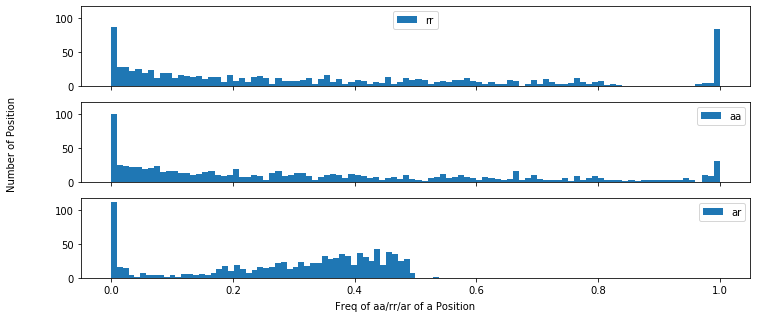

In [10]:
'''
plot the hist of raw data by gentype freq
'''
rr=[]
aa=[]
ar=[]
for k in range(len(sample_stat)):
    t=sample_stat[k]['rr']+sample_stat[k]['ar']+sample_stat[k]['aa']
    rr.append(sample_stat[k]['rr']/t)
    aa.append(sample_stat[k]['aa']/t)
    ar.append(sample_stat[k]['ar']/t)

fig, (ax1,ax2,ax3) =plt.subplots(3, 1, sharex=True, sharey=True, figsize=(12,5))

ax1.hist(rr,bins=100,label="rr")
ax1.legend()

ax2.hist(aa,bins=100,label="aa")
ax2.legend()

ax3.hist(ar,bins=100,label="ar")
ax3.legend()

fig.text(0.5, 0.04, 'Freq of aa/rr/ar of a Position', ha='center')
fig.text(0.04, 0.5, 'Number of Position', va='center', rotation='vertical')

Text(0.04, 0.5, 'Number of Position')

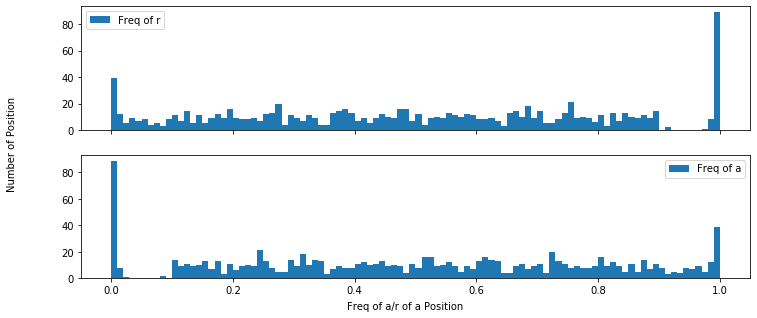

In [11]:
'''
plot the hist of raw data by allele freq
'''
r=[]
a=[]
c=[]
for k in range(len(sample_stat)):
    t=sample_stat[k]['rr']+sample_stat[k]['ar']+sample_stat[k]['aa']
        
    rf=sample_stat[k]['rr']+sample_stat[k]['ar']/2
    rf=rf/t

    af=sample_stat[k]['aa']+sample_stat[k]['ar']/2
    af=af/t
            
    r.append(rf)
    a.append(af)
    c.append(k)

fig, (ax1,ax2) =plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,5))

ax1.hist(r,bins=100,label="Freq of r")
ax1.legend()

ax2.hist(a,bins=100,label="Freq of a")
ax2.legend()


fig.text(0.5, 0.04, 'Freq of a/r of a Position', ha='center')
fig.text(0.04, 0.5, 'Number of Position', va='center', rotation='vertical')

### def Functions

In [0]:
def test_real(n,genotype_raw):
# input: the pool size n, a line of vcf genotype_raw
# run the pooling & decoding strategy, access it
# return: the number of xxxxx
    pools_size=n
    pooling_size=pools_size*pools_size
    pool_shape=(n,n)
    id_len=8
    pools_nb=n*2

    genotype=np.asarray(genotype_raw)
    genotype=np.random.permutation(genotype)
    pooling_nb=int(genotype.shape[0]/pooling_size)

    #sample info
    sample=generate_id(genotype)
    sample_counter=collections.Counter(sample)

    # pooling + decoding + assess
    mis=0
    correct=0
    wrong=0
    for i in range(pooling_nb):
        sample_gt=genotype[i*pooling_size:(i+1)*pooling_size]
        sample_id=sample[i*pooling_size:(i+1)*pooling_size]
        #start pooling
        mypooling = SNPsPool(pool_shape,id_len,pools_nb,pools_size)
        mypooling.set_subset(sample_id)
        mypooling.set_line_values(sample_id,sample_gt)
        decoded_gt=mypooling.decode_genotypes_gt(sample_gt)
        #assess decoded_gt
        acc=access_pool(sample_gt,decoded_gt)
        acc_count=collections.Counter(acc)
        mis=mis+acc_count['mis']
        correct=correct+acc_count['correct']
        wrong=wrong+acc_count['wrong']
    return mis,correct,wrong,sample_counter['aa'],sample_counter['ar'],sample_counter['rr'],pooling_nb

In [0]:
def average_test(n,genotype_raw,repeat):
# input: the pool size n, a line of vcf genotype_raw, the repeat number
# run the test_real func several times 
# return: the average number of xxxxx
    mis=0
    correct=0
    wrong=0
    effort_add=0
    total=len(genotype_raw)
    for i in range(repeat):
        a=test_real(n,genotype_raw)
#         mis=mis+a[0]
        correct=correct+a[1]
        wrong=wrong+a[2]
        mis=mis+(total-a[1]-a[2]) #since there's samples unpooled
        effort_add=effort_add+a[6]*n*2
    effort=mis+effort_add
    return mis/repeat,correct/repeat,wrong/repeat,effort/repeat

## test 

In [0]:
n=2 #pool size
repeat=1

In [0]:
mis_arr=[]
correct_arr=[]
wrong_arr=[]
effort_arr=[]
for variant in VCF(file_path):
    genotype_raw = variant.genotypes
    res=average_test(n,genotype_raw,repeat)
    mis_arr=mis_arr+[int(res[0])] #mis
    correct_arr=correct_arr+[int(res[1])]
    wrong_arr=wrong_arr+[int(res[2])]
    effort_arr=effort_arr+[int(res[3])]


Text(0.04, 0.5, 'Number of Position')

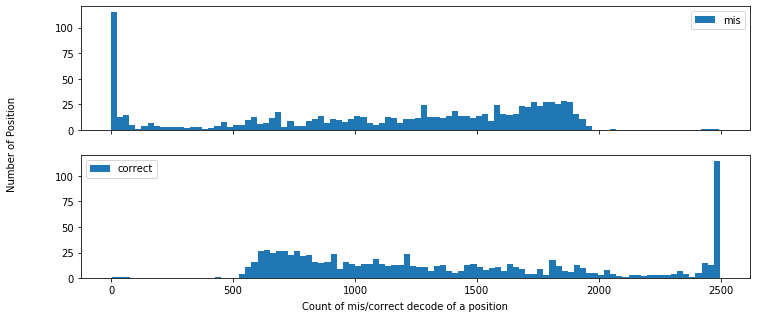

In [16]:
#show the hist of mis and correct
fig, (ax1,ax2) =plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,5))

ax1.hist(mis_arr,bins=100,label="mis")
ax1.legend()

ax2.hist(correct_arr,bins=100,label="correct")
ax2.legend()

fig.text(0.5, 0.04, 'Count of mis/correct decode of a position', ha='center')
fig.text(0.04, 0.5, 'Number of Position', va='center', rotation='vertical')


In [1]:
mis1000_arr=[]
correct1000_arr=[]
wrong_arr1000=[]
effort1000_arr=[]
ori_arr=[]
control_arr=[]
for n in range(6):
  n=n+1
  mis_arr=[]
  correct_arr=[]
  wrong_arr=[]
  effort_arr=[]
  for variant in VCF(file_path):
      genotype_raw = variant.genotypes
      # control_arr=control_arr+[int(i)]
      res=average_test(n,genotype_raw,repeat)
      mis_arr=mis_arr+[int(res[0])] #mis
      correct_arr=correct_arr+[int(res[1])]
      wrong_arr=wrong_arr+[int(res[2])]
      effort_arr=effort_arr+[int(res[3])]

  # get the average of 1000 position
  mis1000=statistics.mean(mis_arr)
  correct1000=statistics.mean(correct_arr)
  wrong1000=statistics.mean(wrong_arr)
  effort1000=statistics.mean(effort_arr)

ori=len(genotype_raw)

mis1000_arr.append(mis1000)
correct1000_arr.append(correct1000)
wrong1000_arr.append(wrong1000)
effort1000_arr.append(effort1000)
ori_arr.append(ori)
control_arr.append(int(n))

NameError: ignored

In [0]:
l1,=plt.plot(control_arr,mis1000_arr)
l2,=plt.plot(control_arr,correct1000_arr)
l3,=plt.plot(control_arr,wrong1000_arr)
l4,=plt.plot(control_arr,effort1000_arr)
l5,=plt.plot(control_arr,ori_effort)
plt.legend(handles=[l1,l2,l3,l4,l5],labels=['missing','correct','wrong','effort','ori_effort'],loc='best')
plt.title('Test with real data')
plt.xlabel('Pool size')
plt.ylabel('Results')
plt.show()